In [1]:
options(future.globals.maxSize = 4 * 1024^3)

In [23]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(Matrix)
library(future)
library(future.apply)

In [3]:
library(Clonotrace)

### data

We first read in data. The demo data is from a public in vitro longitudinal experiment to monitor the hematopoiesis (https://www.science.org/doi/10.1126/science.aaw3381). You can download the demo data from: https://upenn.box.com/s/9bxv50lueelrrf5zv4ked20dlkalrtir

In [4]:
seurat_object = readRDS("../../hematopoiesis.rds")

In [5]:
pca = seurat_object@reductions$pca@cell.embeddings
umap = as.data.frame(seurat_object@reductions$umap@cell.embeddings)
cell_meta = seurat_object@meta.data

Within this data, there are 34782 cells are sampled at 3 time points.

In [6]:
table(cell_meta$Time.point)


    2     4     6 
 3407 11101 20274 

This data has a simple cell type compistion with only 3 cell types:

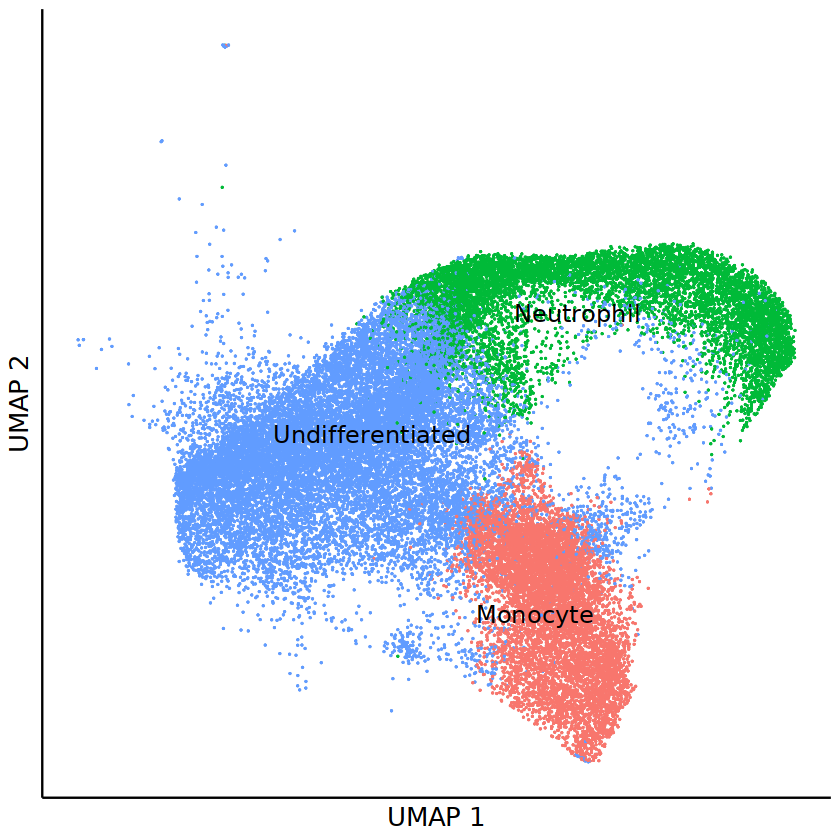

In [7]:
cell_type_umap = dimplot(embedding = umap,annot = cell_meta,color_by = "Cell.type.annotation",size = 0.1,label_size = 5)+
NoLegend()+
theme(axis.text = element_blank(),  
      axis.ticks = element_blank())+
xlab("UMAP 1")+ylab("UMAP 2")
cell_type_umap

For a higher resolustion in the downstream analysis, we further cluster cells into 9 cell clusters.

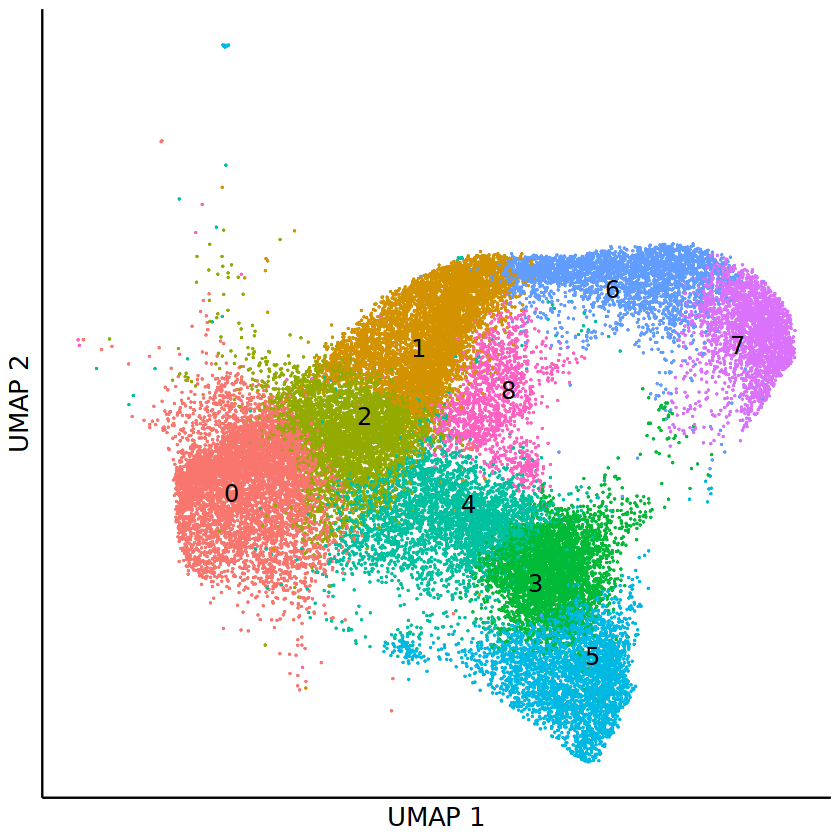

In [8]:
cell_cluster_umap = dimplot(embedding = umap,annot = cell_meta,color_by = "cluster",size = 0.1,label_size = 5)+
NoLegend()+
theme(axis.text = element_blank(),  
      axis.ticks = element_blank())+
xlab("UMAP 1")+ylab("UMAP 2")
cell_cluster_umap

### clone label spreading

We first build a cell kNN graph based within the PCA space:

In [9]:
cell_knn = embedding2knn(embedding = as.matrix(pca),k = 30,mode = "connectivity",if_self = FALSE)
cell_knn = compute_transition(cell_knn)

Here we define a clone as a population of cells which share the same lineage barcode at the same time point. Based on this definition there are 8108 clones in total. 802 out of them expanded over 10 cells.

In [10]:
clone_size = cell_meta %>% group_by(clone) %>% summarise(count = n())
expanded_clones = clone_size %>% filter(count >=10)

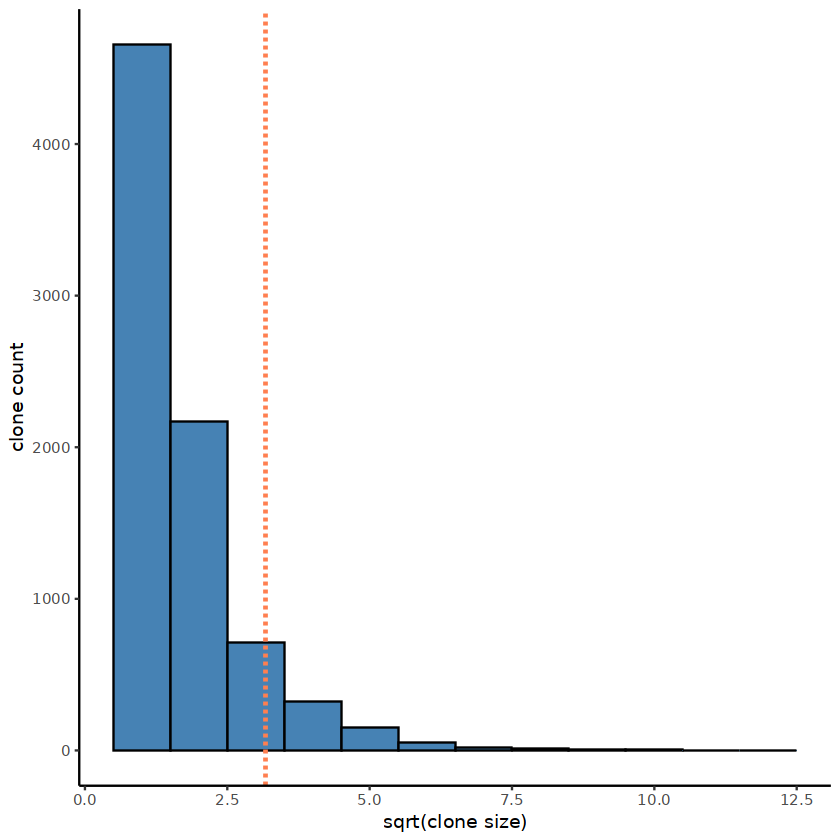

In [11]:
clone_size_hist = ggplot(clone_size)+
geom_histogram(aes(x = sqrt(count)),binwidth = 1,color = "black",fill = "steelblue")+
geom_vline(xintercept = sqrt(10),linetype = "dashed",color = "coral",linewidth = 1)+
theme_classic()+
xlab("sqrt(clone size)")+
ylab("clone count")
clone_size_hist

Then we could spread the clone label in the cell graph to smooth the cell density in those expanding clones. There is a bootstrap during this process to filter out propogation with high deviance, usually in regions with high density of lowly expanded or unexpanded clones. So it's better to run this in parallel.

In [12]:
cell_clone = data.frame(cell = rownames(cell_meta),clone = cell_meta[,"clone"]) %>% 
            mutate(clone = if_else(clone %in% expanded_clones$clone, clone, NA_character_))

In [13]:
start = Sys.time()
plan(multisession,workers = 8)
clone_labels = label_spreading_bootstrap(adj = cell_knn,labels = cell_clone$clone,
                                              alpha = 0.6, sample_rate = 0.8,sample_n = 48)
end = Sys.time()
print(end-start)

Time difference of 6.524958 mins


In [14]:
cell_clone_prob_raw = clone_labels[[1]]
deviance = clone_labels[[2]]

In [15]:
rownames(cell_clone_prob_raw) = rownames(cell_meta)

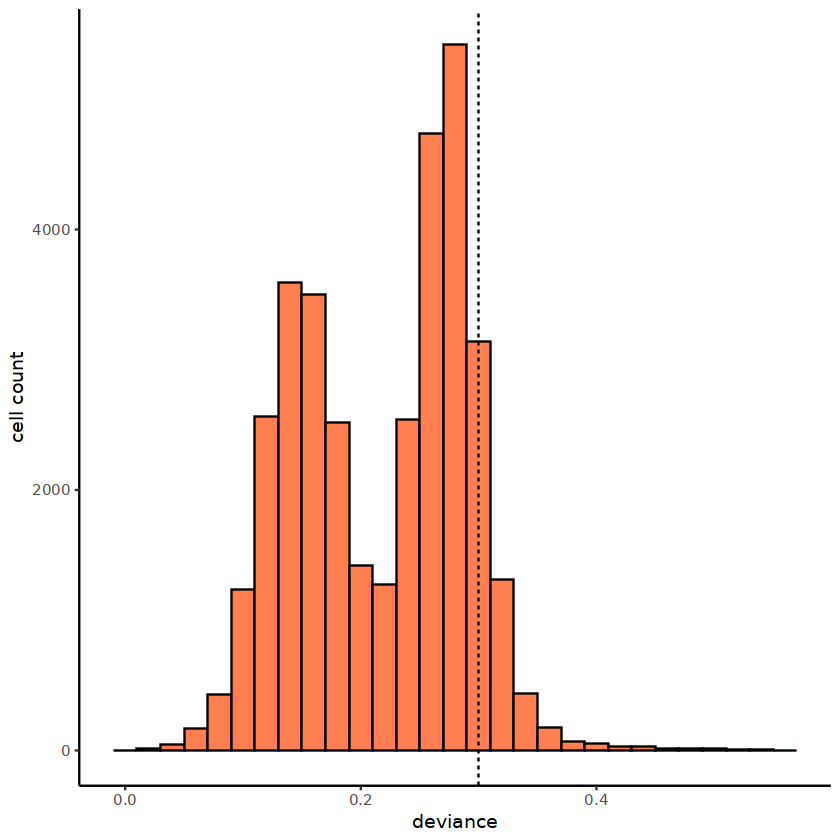

In [16]:
deviance_hist = ggplot()+
geom_histogram(aes(x = deviance),fill = "coral",color = "black",binwidth = 0.02)+
geom_vline(xintercept = 0.3,linetype = "dashed")+
theme_classic()+
ylab("cell count")
deviance_hist

We can visualize the deviance of clone label spreading in each cell via cell UMAP, and here we use the 0.3 as the upper bound threshold for deviance. Cells with high deviance are enriched in undifferentiated cells, which due to they haven't proliferated enough to expand their clones.

In [17]:
cell_meta$deviance = deviance

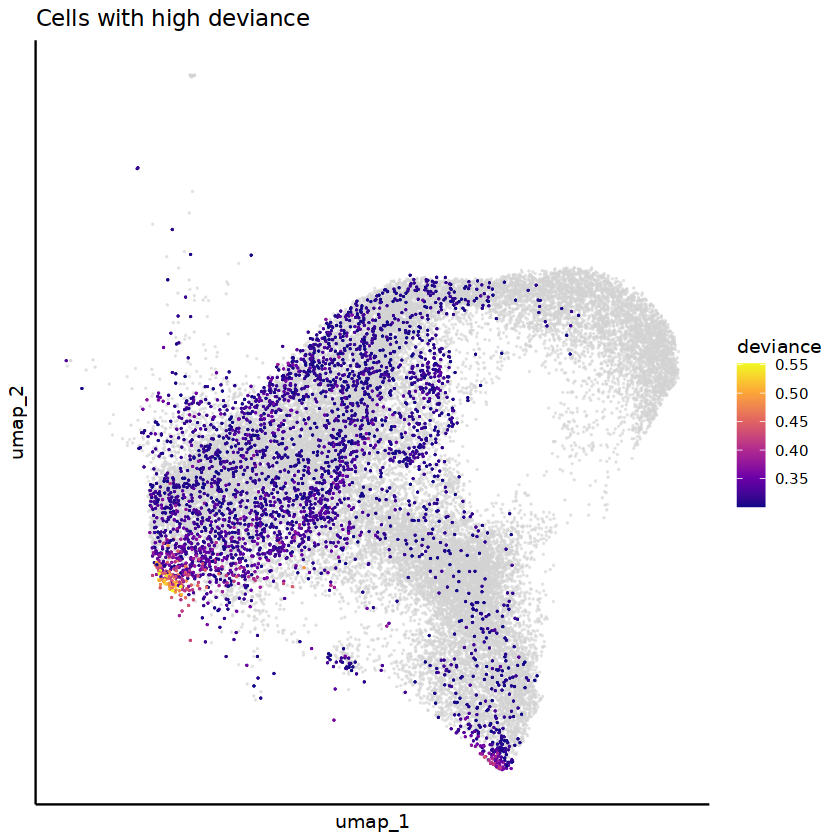

In [18]:
deviance_umap = dimplot(umap,annot = cell_meta %>% filter(deviance > 0.3),color_by = "deviance",label = FALSE,size = 0.1)+
scale_color_viridis_c(name = "deviance",option = "plasma")+
theme_classic()+
theme(axis.text = element_blank(),  
      axis.ticks = element_blank())+
ggtitle("Cells with high deviance")
deviance_umap

Then we filter out cells with high deviance, and sparsify the cell-to-clone probablity by keeping top 90% mass

In [20]:
rownames(cell_clone_prob_raw) = rownames(cell_meta)

In [21]:
cell_clone_prob = cell_clone_prob_raw[deviance < 0.3,]
cell_clone_prob = cell_clone_prob/rowSums(cell_clone_prob)

In [24]:
cell_clone_prob = mat_sparsify(mat = cell_clone_prob,row_mass = 0.9,col_mass = 0.9)
cell_clone_prob = cell_clone_prob/rowSums(cell_clone_prob)
cell_clone_prob = Matrix(cell_clone_prob, sparse = TRUE)

In [25]:
colnames(cell_clone_prob) = names(table(cell_clone$clone))

We can use an example to show how the cell clone assignment is smoothed during this process:

In [26]:
example_clone = "Lineage-1193-6"

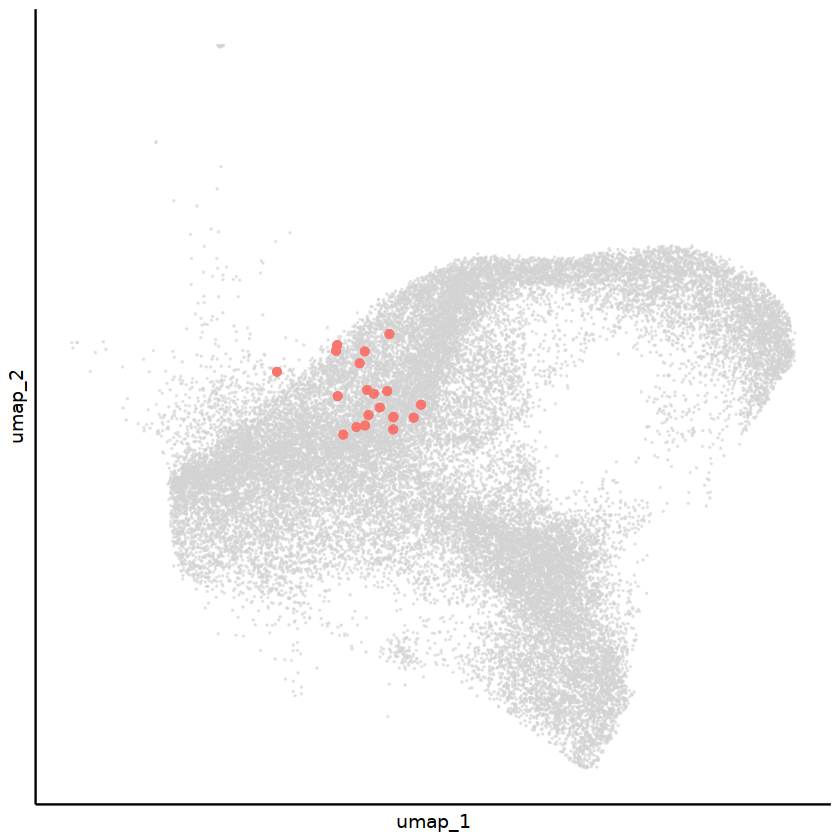

In [27]:
clone_example_umap_raw = dimplot(umap,annot = cell_meta %>% filter(clone == example_clone) %>% mutate(group = "1"),
                                 color_by = "group",label = FALSE,size = 2)+
theme_classic()+
NoLegend()+
theme(axis.text = element_blank(),    
      axis.ticks = element_blank())

clone_example_umap_raw

In [28]:
cell_meta$prob = NA
cell_meta[rownames(cell_clone_prob),]$prob = cell_clone_prob[,example_clone]

In [29]:
umap$prob = cell_meta$prob

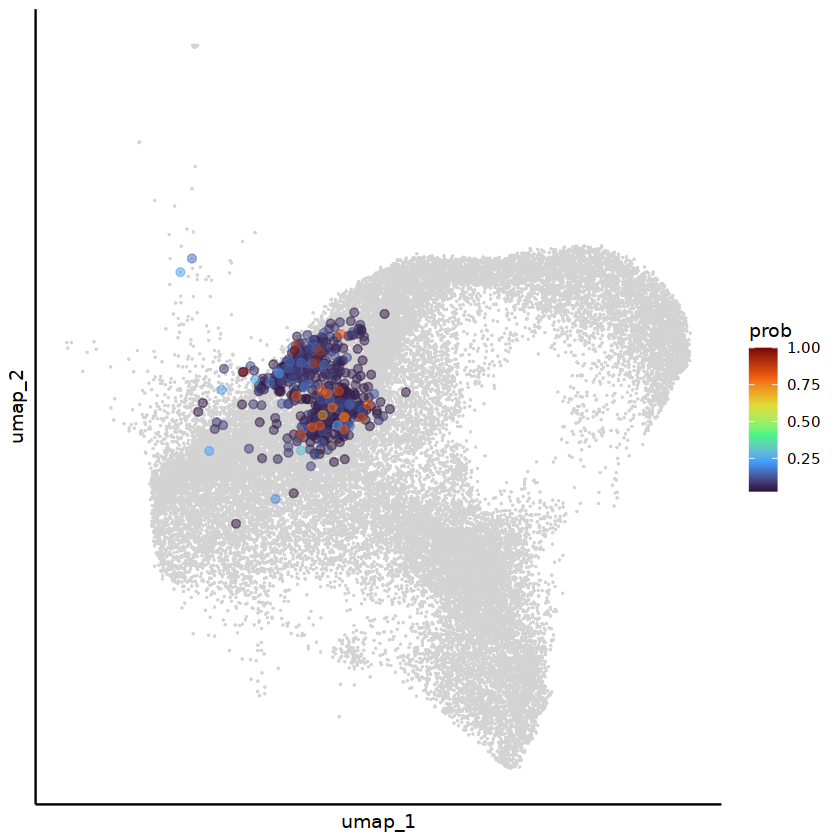

In [30]:
clone_example_umap_smooth = ggplot(mapping = aes(x= umap_1,y = umap_2))+
geom_point(data = umap,color = "lightgrey",size = 0.1)+
geom_point(data = umap %>% filter(prob > 0.025) %>% arrange(prob),
           aes(color = prob),size = 2,alpha = 0.5)+
scale_color_viridis_c(name = "prob",option = "turbo")+
theme_classic()+
theme(axis.text = element_blank(),   
      axis.ticks = element_blank())
clone_example_umap_smooth = ggrastr::rasterize(clone_example_umap_smooth,layers='Point', dpi=300)
clone_example_umap_smooth

### Clonewise transcriptomic distance

After we smooth the cell density for each expanded clone over the cell transcriptomic embedding, we can measure their cell distribution difference via optimal transportation distance. 

We provide two methods for this, the first one calculate the exact optimal transportation distance, and the second one is a faster approximation, but less accurate. You can switch the modes by the `exact` parameter in the `clone_disance` function.

In [ ]:
# not run
plan(multisession, workers = 8)
### exact OT distance
clone_dis = clone_disance(as.matrix(pca),cell_clone_prob,outpath = "./",exact = TRUE, cores = 8)
### nearest neighbor distance approximation
clone_dis = clone_disance(as.matrix(pca),cell_clone_prob,outpath = "./",exact = FALSE)

This step is time and memory consuming, which can take hours even with the approximation. We strongly recommend to put this step in a server or cluster and run it with multiple cores. (As a reference, the approximation method takes 40 minutes to run on the HPC paralleled with 4 cores using 8 Gb RAM).

Here for time efficiency, we can use the pre-computed clone-wise distance for downstream applicaitons.

In [31]:
file_path <- system.file("extdata", "clone_graph_dis.rds", package = "Clonotrace")
clone_dis = readRDS(file_path)

### clone embedding visualization

We first cluster clones using leiden algorithm and visualize the clone community in the UMAP. 

In [32]:
set.seed(1230)
clone_cluster = leiden_dis(dismat = clone_dis,k = 20,resolution = 0.5,if_umap = TRUE)
clone_cluster_center = clone_cluster %>% group_by(cluster) %>% summarise_all(median)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



In [33]:
clone_cluster$mass = colSums(cell_clone_prob)

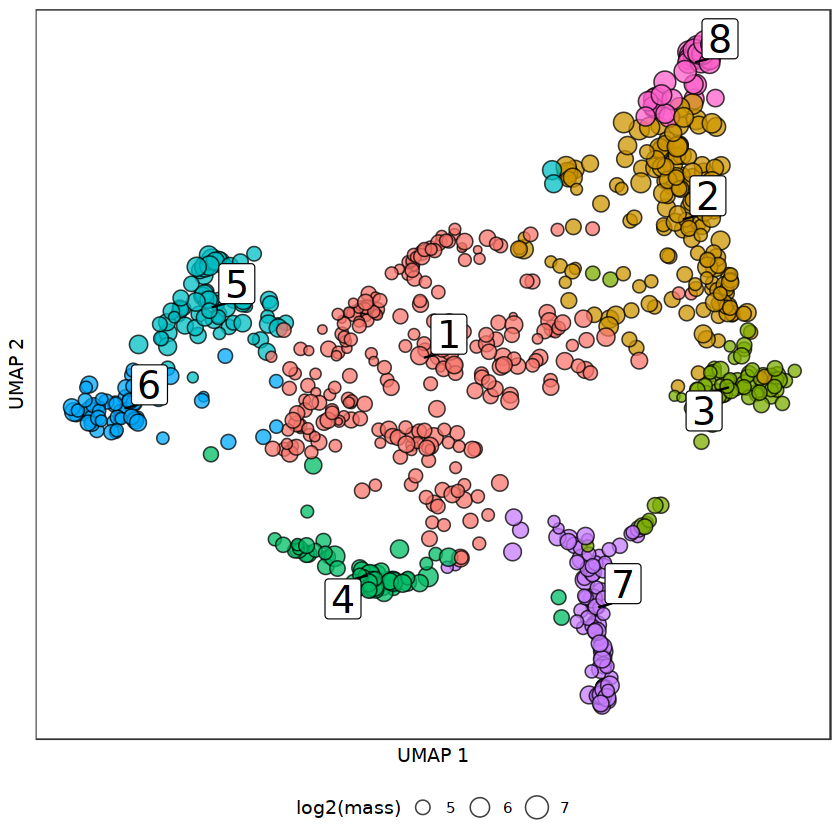

In [34]:
clone_leiden_umap = ggplot(mapping = aes(x = umap1,y = umap2))+
geom_point(data = clone_cluster,aes(fill = cluster,size = log2(mass)),pch=21,color = "black",alpha = 0.75)+
ggrepel::geom_label_repel(data = clone_cluster_center,aes(label = cluster),size = 8)+
theme_bw()+
theme(axis.text = element_blank(),   
      axis.ticks = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank())+
guides(fill = guide_legend(override.aes = list(size=5)))+
guides(fill = "none")+
theme(legend.position = "bottom")+
xlab("UMAP 1")+ylab("UMAP 2")
clone_leiden_umap

We can also visualize the clone embedding in other low dimension reduction like diffusion map:

In [35]:
clone_leiden_dm <- diffusionMap::diffuse(clone_dis,maxdim = 30)
clone_leiden_dm_coord = as.data.frame(clone_leiden_dm$X)
colnames(clone_leiden_dm_coord) = paste("dm",1:ncol(clone_leiden_dm_coord),sep = "")
rownames(clone_leiden_dm_coord) = rownames(clone_cluster)

Performing eigendecomposition
Computing Diffusion Coordinates
Used default value: 11 dimensions
Elapsed time: 2.848 seconds


In [36]:
dm_cluster_center = clone_leiden_dm_coord %>% group_by(clone_cluster$cluster) %>% summarise_all(median)
colnames(dm_cluster_center)[1] = "cluster"

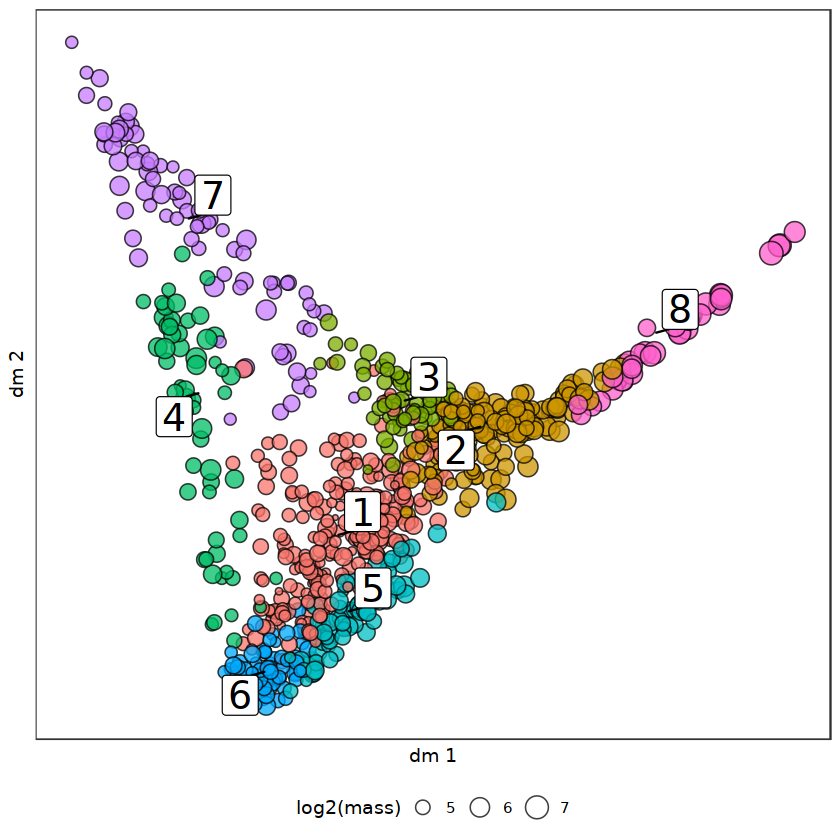

In [37]:
clone_leiden_diffmap = ggplot(mapping = aes(x = dm1,y = dm2))+
geom_point(data = clone_leiden_dm_coord,aes(fill = clone_cluster$cluster,size = log2(clone_cluster$mass)),
           pch=21,color = "black",alpha = 0.75)+
ggrepel::geom_label_repel(data = dm_cluster_center,aes(label = cluster),size = 8)+
theme_bw()+
theme(axis.text = element_blank(),    # Remove axis numbers (labels)
      axis.ticks = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank())+
guides(fill = "none",size = guide_legend(title = "log2(mass)"))+
theme(legend.position = "bottom")+
xlab("dm 1")+ylab("dm 2")
clone_leiden_diffmap

Diffusion map is good to layout continous movement of clones over time.

In [38]:
clone_cluster = clone_cluster %>% mutate(clone = rownames(clone_cluster)) %>% 
                                  mutate(lineage = substr(clone,start = 1,stop = nchar(clone)-2),
                                  time = substr(clone,start = nchar(clone),stop = nchar(clone))) %>% 
                                  mutate(time = paste("day",time,sep = ""))

In [39]:
clone_link = long2wide(clone_cluster %>% dplyr::select(lineage,time,clone),
                       row_names_from = "lineage",
                       col_names_from = "time",
                       values_from = "clone",
                       symmetric = FALSE)
clone_link = na.omit(clone_link)

In [40]:
colnames(clone_link) = c("start","end")

In [41]:
clone_link_coord = cbind(clone_link,
                         clone_leiden_dm_coord[clone_link$start,c("dm1","dm2")],
                         clone_leiden_dm_coord[clone_link$end,c("dm1","dm2")],
                         clone_cluster[clone_link$start,"cluster"],
                         clone_cluster[clone_link$end,"cluster"])
colnames(clone_link_coord) = c("start","end","xdm1","xdm2","ydm1","ydm2","x_cluster","y_cluster")

In [42]:
sub_annot = clone_cluster %>% filter(lineage %in% rownames(clone_link_coord))
sub_dm_coord = clone_leiden_dm_coord[rownames(sub_annot),]

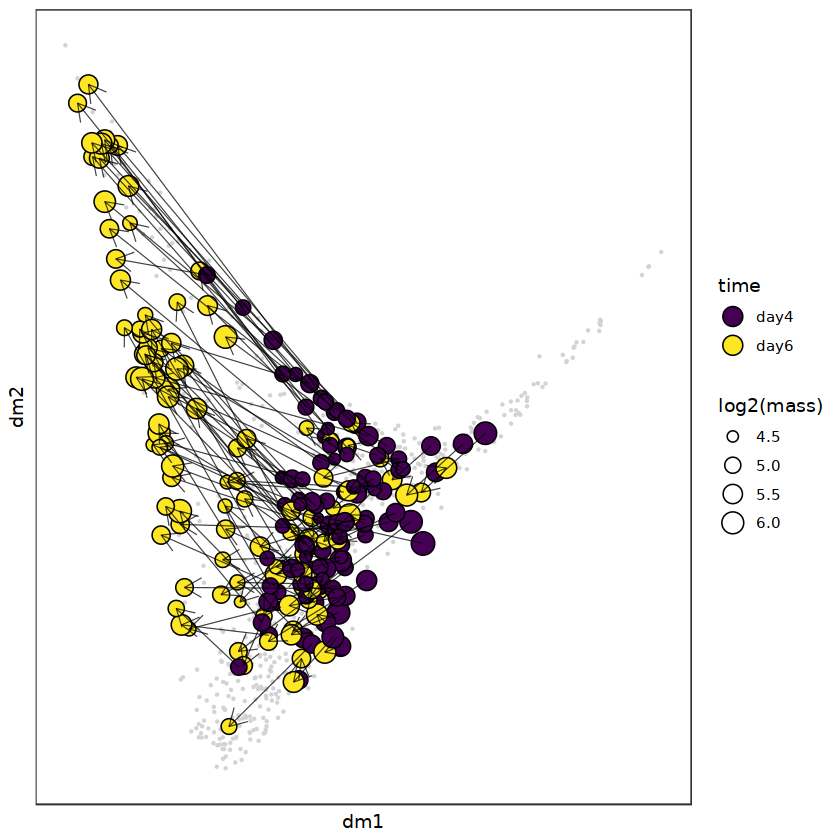

In [43]:
clone_leiden_diffmap_arrow = ggplot()+
geom_point(data = clone_leiden_dm_coord,aes(x = dm1,y = dm2),size = 0.2,color = "lightgrey")+
geom_point(data = sub_dm_coord,aes(x = dm1,y = dm2,fill = sub_annot$time,size = log2(sub_annot$mass)),shape = 21)+
geom_segment(data = clone_link_coord,aes(x = xdm1,y = xdm2,xend = ydm1,yend = ydm2),
             arrow = arrow(length = unit(0.03, "npc")),linewidth = 0.25,alpha = 0.75)+
scale_fill_viridis_d(name = "time")+
theme_bw()+
theme(axis.text = element_blank(),    # Remove axis numbers (labels)
      axis.ticks = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank())+
guides(fill = guide_legend(override.aes = list(size=5)),
       size = guide_legend(title = "log2(mass)"))
clone_leiden_diffmap_arrow

### profile projection in cell embedding

After we cluster the clones into profiles, with the cell clone probabilty, we can also map cells to profiles:

In [44]:
clone_profile = clone_cluster %>% dplyr::select(clone,cluster) %>% mutate(flag = 1)
clone_profile = long2sparse(long = clone_profile,row_names_from = "clone",col_names_from = "cluster",values_from = "flag")

In [45]:
cell_profile_prob = cell_clone_prob %*% clone_profile[colnames(cell_clone_prob),]
rownames(cell_profile_prob) = rownames(cell_clone_prob)

For cells with profile probability higher than 0.5, we assign it with a profile label:

In [46]:
cell_meta$profile = NA
cell_meta[rownames(cell_profile_prob),]$profile = apply(cell_profile_prob,1,function(x){
    if(max(x) > 0.5){
        return(which(x == max(x))[1])
    }
    else{
        return(NA)
    }
})
cell_meta = cell_meta %>% mutate(profile = as.factor(profile))

In [47]:
cell_meta$profile_prob = NA
cell_meta[rownames(cell_profile_prob),]$profile_prob = apply(cell_profile_prob,1,max)

Then we can visualize how profile flow over the cell embedding:

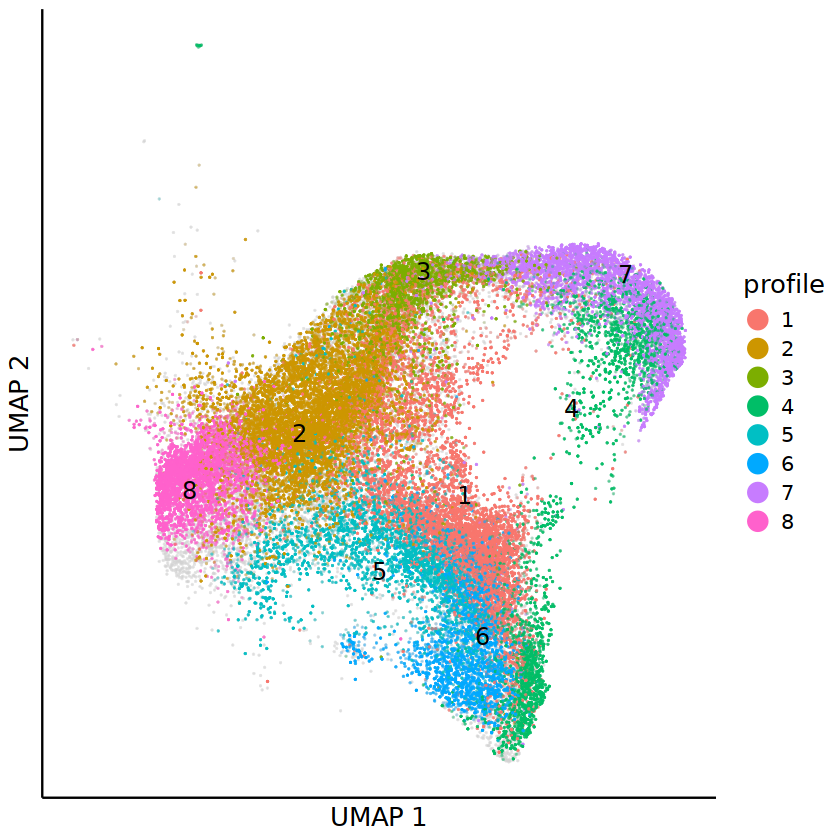

In [48]:
cell_profile_umap = dimplot(embedding = umap,annot = cell_meta,color_by = "profile",
                            size = 0.1,alpha_by = "profile_prob",label = TRUE)+
theme(axis.text = element_blank(), 
      axis.ticks = element_blank())+
xlab("UMAP 1")+ylab("UMAP 2")+
guides(alpha = "none",color = guide_legend(override.aes = list(size=5)))
cell_profile_umap

Obvisouly, profile 5 and 6 monopotently differentiate to monocytes and profile 3 and 7 monopotently differentiate to netriphil, while profile 1 and 4 denote the bipotent differenitation.

### Clone level pseudotime

We first generate the clone level pseudotime by diffusion pseudotime in the clone embedding. Here we use the clone distance projection in the MDS space as the clone embedding.

In [49]:
clone_mds = MASS::isoMDS(as.matrix(clone_dis), k=30)
clone_embedding = clone_mds$points
colnames(clone_embedding) = paste("mds",1:ncol(clone_embedding),sep = "_")
rownames(clone_embedding) = rownames(clone_cluster)

initial  value 6.673968 
iter   5 value 3.757695
iter  10 value 2.922664
iter  15 value 2.544110
iter  20 value 2.367482
iter  25 value 2.291132
iter  30 value 2.251516
iter  35 value 2.225022
iter  40 value 2.207040
final  value 2.194391 
converged


This step is kind slow, here we also read a pre-computed MDS embedding for the downstream analysis:

In [85]:
file_path <- system.file("extdata", "clone_mds.tsv", package = "Clonotrace")
clone_embedding = read.table(file_path,sep = "\t",header = TRUE)

Warning message in file(file, "rt"):
“file("") only supports open = "w+" and open = "w+b": using the former”


ERROR: Error in read.table(file_path, sep = "\t", header = TRUE): no lines available in input


Here we choose the cell cluster 0 as the starting cluster for diffusion pseudotime. The `clone_dpt` function would automatically choose the clone which has the highest enrichment in this starting cluster to be the root of diffusion pseudotime.

In [53]:
clone_t = clone_dpt(clone_embedding = clone_embedding,cell_meta = cell_meta,
                    clone_col = "clone",cluster_col = "cluster",start_cluster = "0")

In [54]:
clone_cluster$dpt = clone_t

We can then visualize the clone level pseudotime in the diffusion map:

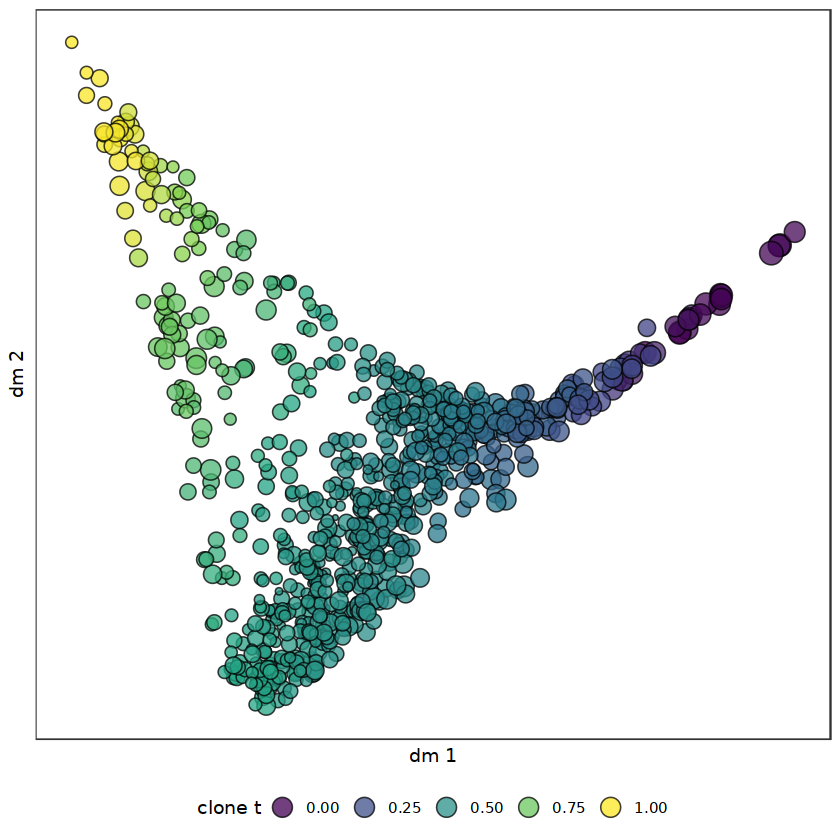

In [55]:
clone_dpt_diffmap = ggplot(mapping = aes(x = dm1,y = dm2))+
geom_point(data = clone_leiden_dm_coord,aes(fill = clone_cluster$dpt,size = log2(clone_cluster$mass)),
           pch=21,color = "black",alpha = 0.75)+
theme_bw()+
theme(axis.text = element_blank(),    # Remove axis numbers (labels)
      axis.ticks = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank())+
guides(fill = guide_legend(override.aes = list(size=5)))+
scale_fill_viridis_c(name = "clone t")+
guides(size = "none")+
theme(legend.position = "bottom")+
xlab("dm 1")+ylab("dm 2")
clone_dpt_diffmap

Then we can smooth the clone level pseudotime over the cell embedding by multiplying the clone pseudotime to cell clone probability. The pseudotime inference is necessary for the fate driving gene detection in the downstream analysis. 

In [56]:
cell_meta$cell_t = NA
cell_meta[rownames(cell_clone_prob),]$cell_t = cell_clone_prob[,clone_cluster$clone] %*% clone_cluster$dpt

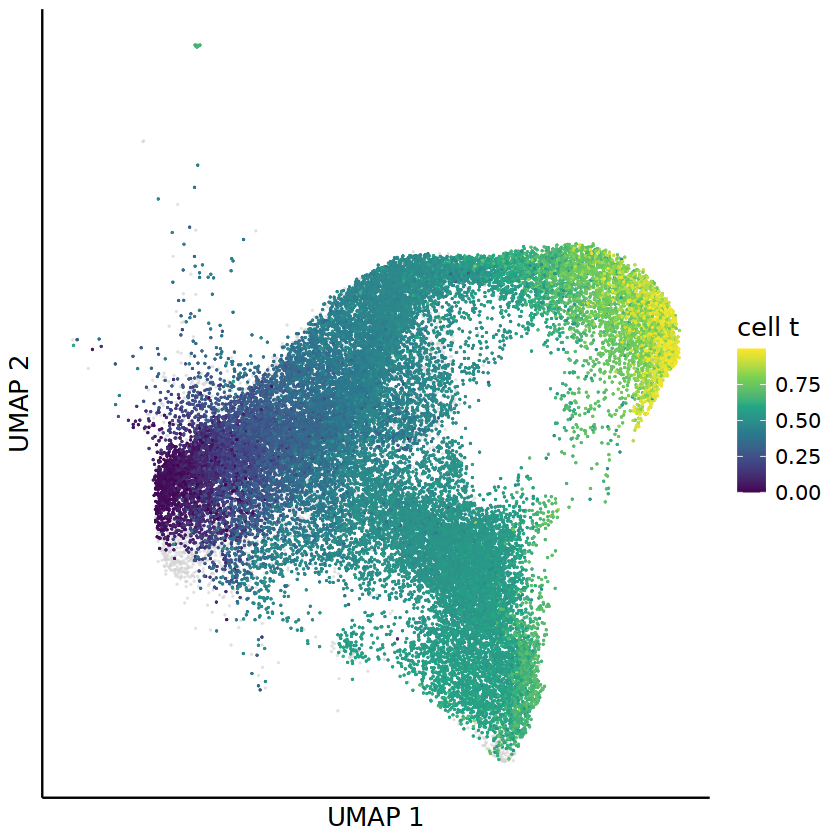

In [57]:
cell_dpt_umap = dimplot(embedding = umap,annot = cell_meta,color_by = "cell_t",
                            size = 0.1,alpha_by = NULL,label = FALSE)+
theme(axis.text = element_blank(), 
      axis.ticks = element_blank())+
xlab("UMAP 1")+ylab("UMAP 2")+
scale_color_viridis_c(name = "cell t")
cell_dpt_umap

### clone weighted cell embedding (optional)

By integrating information from both the clone embedding and the cell embedding, we developed a new visualization method called clone-weighted cell embedding. In this representation, even if two cells are close in the transcriptomic (cell) embedding, they will be pulled apart in the clone-weighted embedding if their corresponding clones are distant in clone space. This embedding can better illustrate the clone level heterogeneity.

In [58]:
cell_k = 30
clone_k = 15
cell_embedding = pca[rownames(cell_clone_prob),]

In [59]:
plan(multisession, workers = 8)
coembed_dis = cell_clone_coembed(cell_embedding,clone_embedding)

This function `cell_clone_coembed` would return a sparse distance matrix, which denotes a weighted kNN network between cells. We can project this kNN network to UMAP for visulization. This step requires a python script.

In [61]:
# set you python path
library(reticulate)
use_python("~/softwares/anaconda3/envs/py3.8/bin/python")

Warning message:
“package ‘reticulate’ was built under R version 4.2.1”


In [65]:
script_path <- system.file("py", "embedding_from_kNN.py", package = "Clonotrace")
source_python(script_path)

In [68]:
source_python(script_path)

In [64]:
cell_coembed_umap = umap_from_knn(coembed_dis,n_neighbors = 10,seed = 512)

ERROR: Error in umap_from_knn(coembed_dis, n_neighbors = 10, seed = 512): could not find function "umap_from_knn"


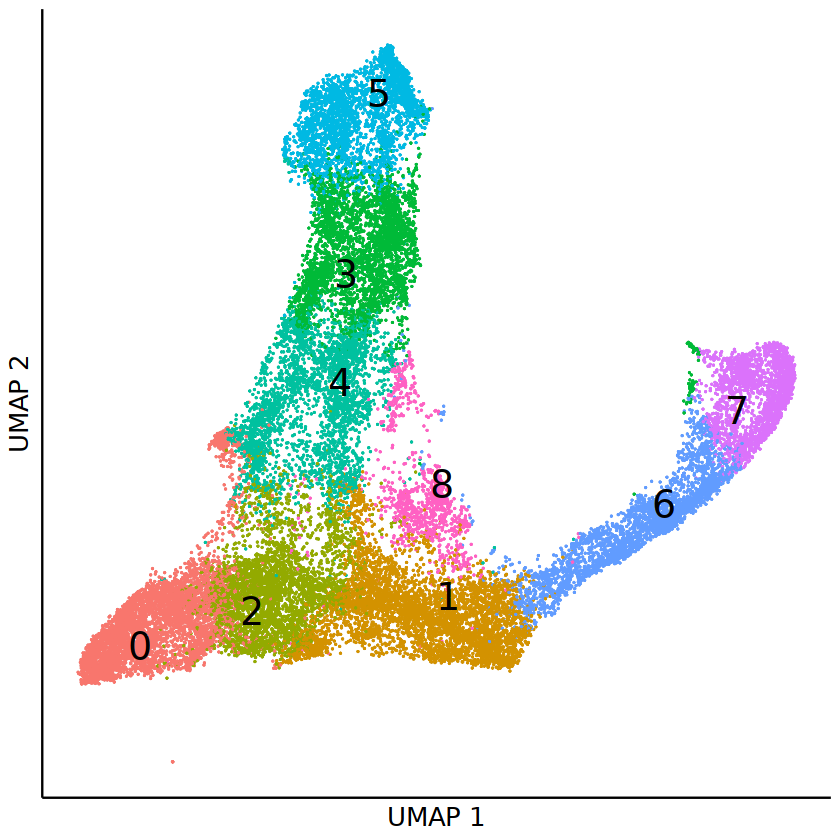

In [380]:
coembed_umap_cluster = dimplot(embedding = cell_coembed_umap,annot = cell_meta,alpha_by = NULL,label_size = 8,
                          color_by = "cluster",size = 0.1,alpha = 1)+
theme(axis.text = element_blank(),    # Remove axis numbers (labels)
      axis.ticks = element_blank())+
xlab("UMAP 1")+ylab("UMAP 2")+
NoLegend()
coembed_umap_cluster

Obviously, there appear two boundaries within the two branchs for monocytes (cluster 4, 3, 5) and neutriphils (cluster 1, 6, 7), which denote the clone level heterogenity. Once we colored cells by the profile identity, we can see the two boundaries seperate the bipoent and unipotent profiles.

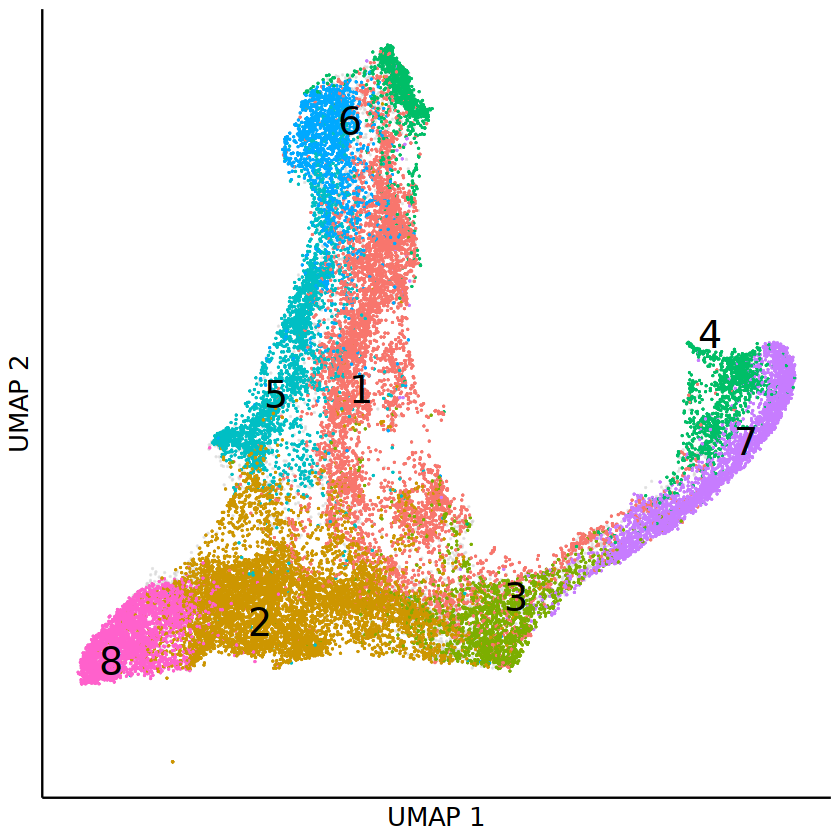

In [381]:
coembed_umap_profile = dimplot(embedding = cell_coembed_umap,annot = cell_meta,alpha_by = NULL,label_size = 8,
                          color_by = "profile",size = 0.1,alpha = 1)+
theme(axis.text = element_blank(),    # Remove axis numbers (labels)
      axis.ticks = element_blank())+
xlab("UMAP 1")+ylab("UMAP 2")+
NoLegend()
coembed_umap_profile

### profile enrichment in each cluster

In the dowsntream analysis we will focus on the early bipotent profiles (profile) and detect early fate-associated genes. To achieve this goal we first do an enrichment test between profiles and clusters to show in which cluster profile 1 has significant high density. And then within the target cluster, we compare the gene expression between profile 1 and other profiles to identify early fate-associated genes.

We first do the cell cluster profile enrichment using permutation test:

In [70]:
enrich = cluster_profile_enrich(cell_profile_prob,cell_meta[rownames(cell_profile_prob),"cluster"],permute_n  = 1000)

We can then visualize the enrichment result using a heatmap:

In [71]:
mass_long = wide2long(enrich[[1]])
mass_long = mass_long %>% mutate(i = rownames(enrich[[1]])[i],
                                 j = colnames(enrich[[1]])[j])
colnames(mass_long) = c("cluster","profile","mass")
mass_long = mass_long %>% group_by(cluster) %>% mutate(freq = mass/sum(mass))
mass_long$pvalue = c(t(enrich[[2]]))

In [72]:
mass_long$signif = "ns"
mass_long$signif[mass_long$pvalue< 0.05] = "*"
mass_long$signif[mass_long$pvalue< 0.01] = "**"
mass_long$signif[mass_long$pvalue< 0.001] = "***"

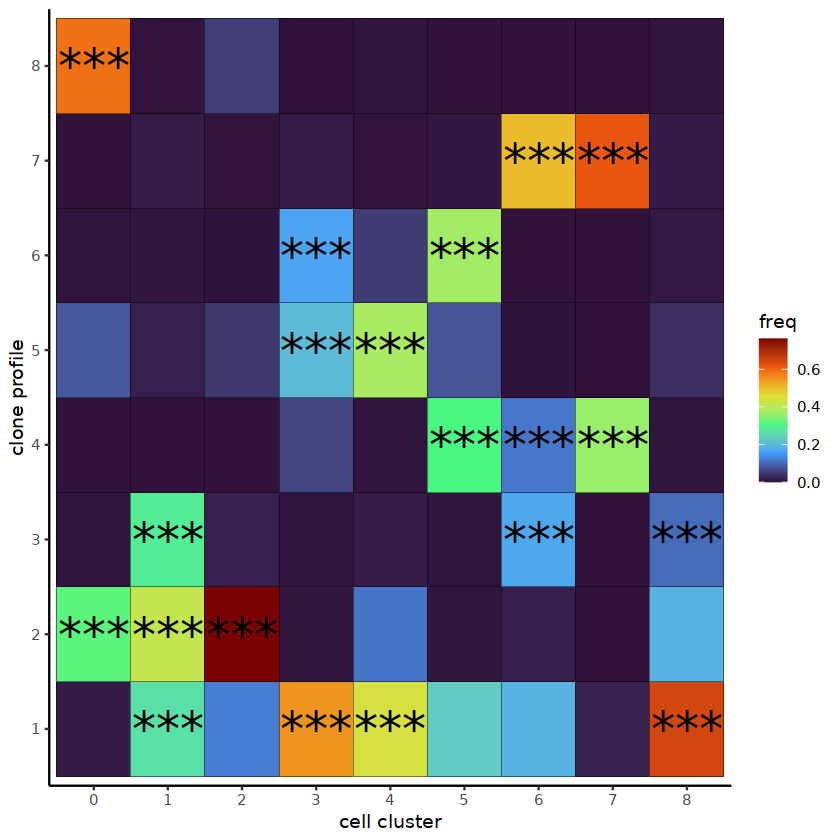

In [73]:
cell_type_profile_enrich_heatmap = ggplot(mass_long,aes(x = cluster,y = profile))+
geom_tile(aes(fill = freq),color = "black")+
scale_fill_viridis_c(option = "turbo")+
geom_text(data = mass_long %>% filter(signif != "ns"),aes(label = signif),size = 10)+
theme_classic()+
xlab("cell cluster")+
ylab("clone profile")
cell_type_profile_enrich_heatmap

From the heatmap we can see that our target profile 1 is enriched in 4 cell clusters, including 1, 3, 4 and 8, within which cluster 1 and 4 are at early differentiation stage. Here, as an example, we will identify genes differentially expressed in profile 1 in cluter 4.

### profile DEG within clusters

In [74]:
exprs = seurat_object@assays$RNA$data

In [75]:
start = Sys.time()
DEG_1_4 = profile_cluster_DEG(profile = "1",cluster = "4",exprs = exprs,cell_meta = cell_meta,cell_profile_prob = cell_profile_prob)
end = Sys.time()
print(end - start)

Time difference of 3.637179 mins


In [76]:
DEG_1_4_sig = DEG_1_4$stat %>% filter(padj < 0.05)
nrow(DEG_1_4_sig)

[1] 2059

In total we identified 2165 genes which are differentially expressed in profile 1 in cluster 4.

Here we can take a look at the top 10 genes with the largest effect size.

In [77]:
DEG_1_4_sig %>% top_n(abs(cohen),n = 10)

stat     pval          mean_diff  cohen      pcali padj
Dmkn    343.7315 2.700662e-136  2.5148280  1.0822856 0     0   
Elane   281.1392 1.901561e-113  2.8276241  0.9931518 0     0   
Fth1    191.7374  1.714705e-79 -5.9160810 -0.8382629 0     0   
H2afy   268.0534 1.410877e-108 -5.8758423 -0.9739037 0     0   
Lcn2    333.1522 1.746739e-132  1.4988499  0.9372692 0     0   
Ly6a    239.9642  5.216386e-98 -2.3617682 -0.9119142 0     0   
Olfml2b 217.7622  1.521792e-89  0.8629008  0.8447858 0     0   
Prtn3   226.3534  7.850266e-93  1.9952254  0.8769203 0     0   
S100a8  295.2479 1.161366e-118  8.8524920  0.8524137 0     0   
Wfdc21  533.0416 2.925756e-201  2.6655881  1.2429065 0     0

We can take `Dmkn` as an example to show how the linear regression model fits for the profile 1 and other profiles in cluster 4 along pseudotime:

In [78]:
test_object = DEG_1_4

In [79]:
null_fit = test_object$design_null %*% test_object$coef[3:4,]
full_fit = test_object$design_null %*% test_object$coef[1:2,]
rownames(null_fit) = rownames(full_fit) = test_object$cell

In [80]:
example_gene = "Dmkn"

In [81]:
cell_meta$exprs = exprs[example_gene,rownames(cell_meta)]

In [82]:
cell_meta$null_exprs = NA
cell_meta[test_object$cell,]$null_exprs = null_fit[,example_gene]
cell_meta$full_exprs = NA
cell_meta[test_object$cell,]$full_exprs = full_fit[,example_gene]

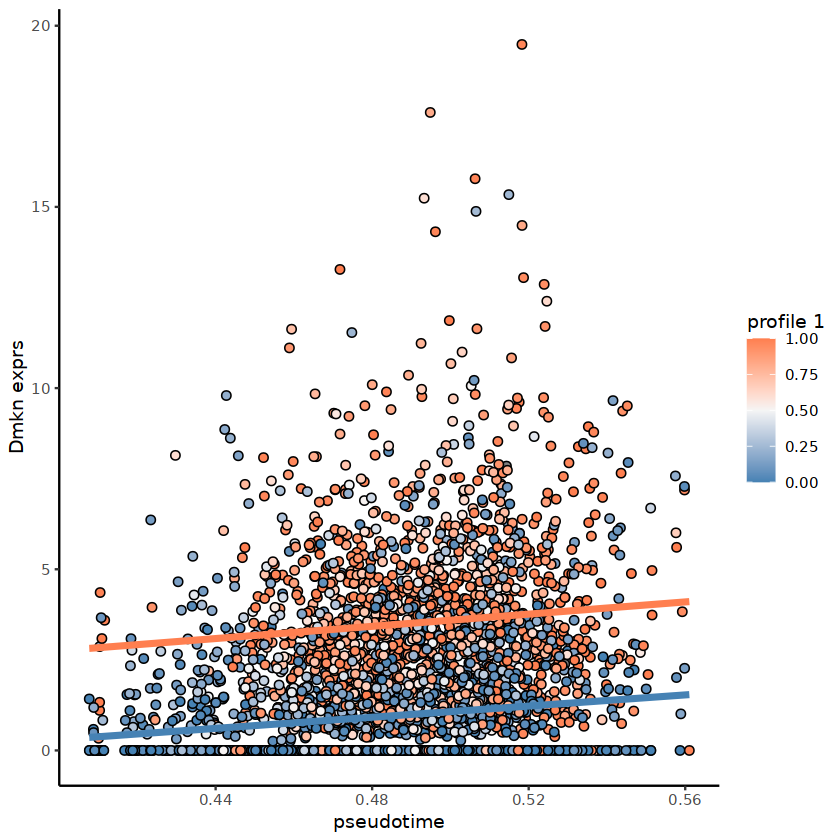

In [83]:
gene_fit_cluster = ggplot(cell_meta[test_object$cell,])+
        geom_point(aes(x = cell_t,y = exprs,fill = cell_profile_prob[test_object$cell,"1"]),size = 2,shape = 21,color = "black")+
        geom_line(aes(x = cell_t,y = null_exprs),color = "steelblue",linewidth = 1.5)+
        geom_line(aes(x = cell_t,y = full_exprs),color = "coral",linewidth = 1.5)+
        scale_fill_gradient2(name = "profile 1",low = "steelblue",mid = "whitesmoke",high = "coral",midpoint = 0.5,limit = c(0,1))+
        theme_classic()+
        xlab("pseudotime")+ylab(paste(example_gene,"exprs",sep = " "))
gene_fit_cluster

We can further visualize the expression for `Dmkn` over the cell UMAP:

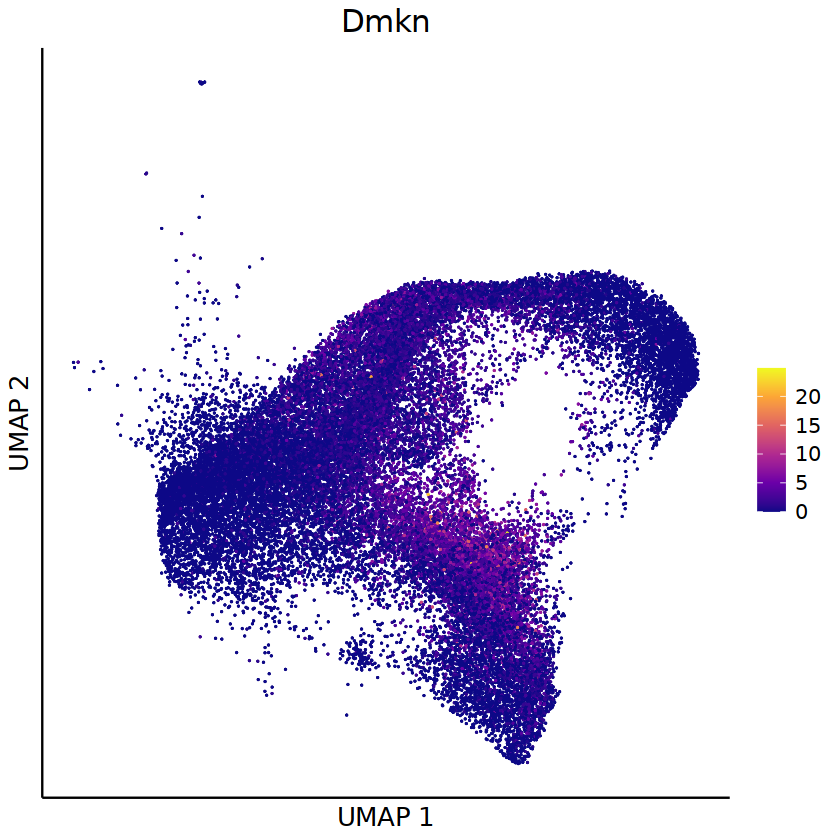

In [84]:
feature_scatter = dimplot(embedding = umap,annot = t(exprs),color_by = example_gene,label  = FALSE,size = 0.1)+
scale_color_viridis_c(name = "",option = "plasma")+
theme(axis.text = element_blank(),    # Remove axis numbers (labels)
      axis.ticks = element_blank(),
      plot.title = element_text(hjust = 0.5),
      legend.position = "right")+
ggtitle(example_gene)+
xlab("UMAP 1")+ylab("UMAP 2")
feature_scatter